# Phase Retrieval

Following Hanser et. al.,

In [1]:
%load_ext autoreload
%autoreload 2
import os
from skimage.external import tifffile as tif
%pylab inline
from psfotf import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
test_data = tif.imread("../fixtures/psf_wl520nm_z300nm_x130nm_na0.85_n1.0.tif")

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1398: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [7]:
from dphutils import scale

In [127]:
from dphplotting import mip, slice_plot

(<matplotlib.figure.Figure at 0x16e8c2f9e80>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016E8D3A62E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000016E8D3C4198>], dtype=object))

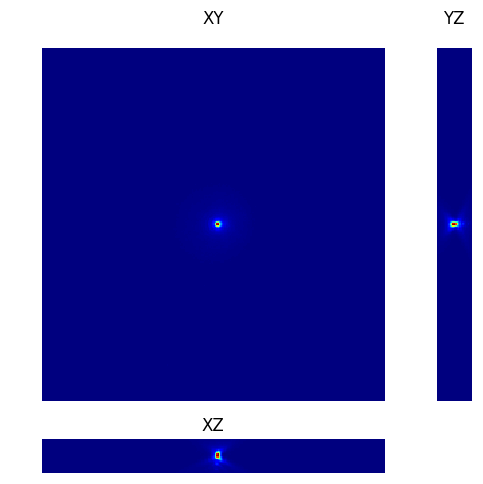

In [4]:
mip(test_data)

In [131]:
psf = HanserPSF(520, 0.8, 1.0, 130, test_data.shape[-1], zrange = (np.arange(test_data.shape[0]) - (test_data.shape[0]-1)/2) * 300)

(<matplotlib.figure.Figure at 0x16e9a3e0f28>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016E9E9BD2E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000016E9ECC0048>], dtype=object))

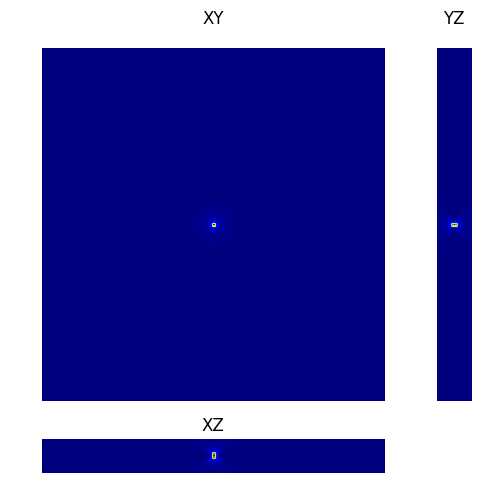

In [132]:
psf.vec_corr = "none"
mip(psf.PSFi)

(<matplotlib.figure.Figure at 0x16e9ed502e8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016E9ED74908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000016EACE35B70>], dtype=object))

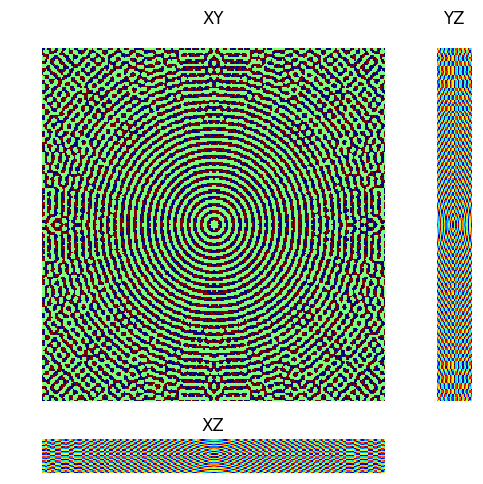

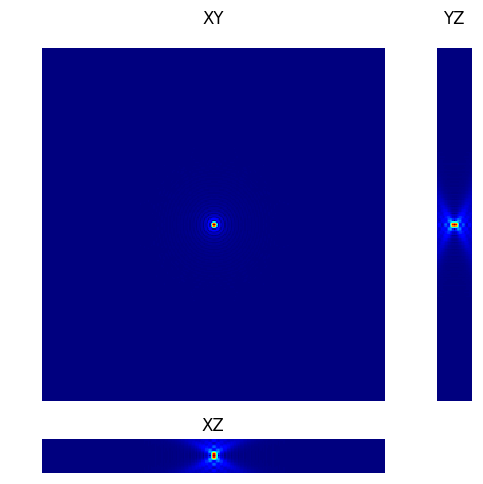

In [133]:
slice_plot(angle(psf.PSFa[0]))
slice_plot(abs(psf.PSFa[0]))

(<matplotlib.figure.Figure at 0x16eaf644ba8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016EAF744FD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000016EAF830F98>], dtype=object))

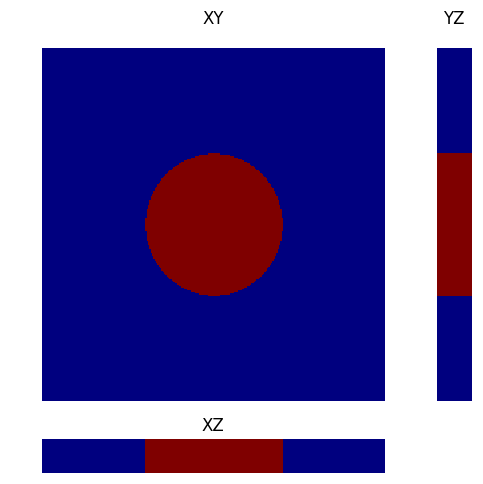

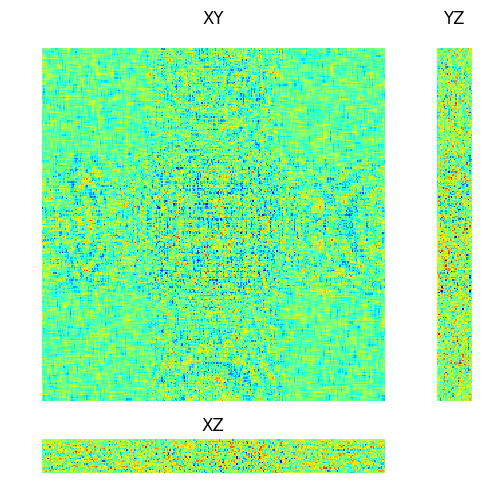

In [150]:
new_pupils = fftn(fftshift(psf.PSFa[0], axes=(1,2)), axes=(1,2)) * psf._calc_defocus(psf.zrange[::-1])
slice_plot(ifftshift(new_pupils).real)
slice_plot(ifftshift(new_pupils).imag)

-3
(5, 256, 256)


(5, 256, 256)

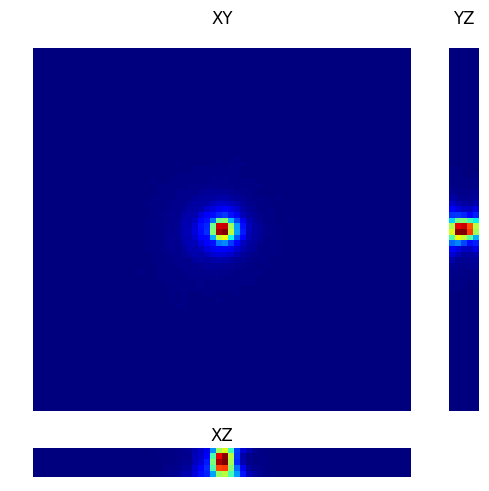

In [227]:
s = test_data.shape
print(-test_data.argmax() + prod(s) // 2 + s[-1]//2)
test_data2 = scale(roll(test_data, -test_data.argmax() + prod(s) // 2 + s[-1]//2))[10:-10]
print(test_data2.shape)
mip(test_data2[[Ellipsis] + [slice(128-32, 128+32)]*2])
test_data2.shape

In [228]:
def retrieve_phase(data, psf, pupil=None):
    if pupil is None:
        pupil = psf._gen_pupil()
    psf._gen_psf(pupil)
    phase = angle(psf.PSFa.squeeze())
    new_psf = sqrt(data) * exp(1j * phase)
    new_pupils = fftn(fftshift(new_psf, axes=(1,2)), axes=(1,2)) * psf._calc_defocus(psf.zrange[::-1])
    return new_pupils.mean(0) * psf._gen_pupil()

In [229]:
psf = HanserPSF(520, 0.85, 1.0, 130, test_data2.shape[-1],
                zrange = (np.arange(test_data2.shape[0]) - (test_data2.shape[0]-1)/2) * 300)
pupil = None
psf._gen_kr()
for _ in range(100):
    pupil = retrieve_phase(test_data2, psf, pupil)

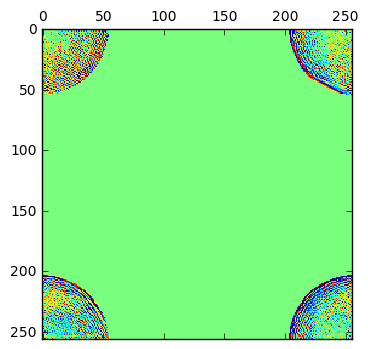

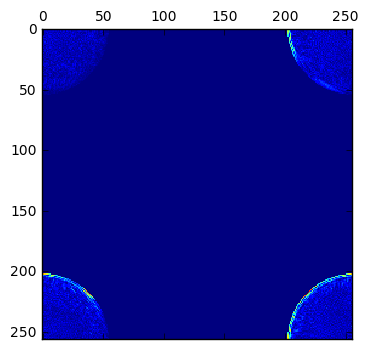

In [230]:
matshow(angle(pupil) * psf._gen_pupil().real)
matshow(abs(pupil))

(<matplotlib.figure.Figure at 0x16eb5469198>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016EB52BF400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000016EB7445208>], dtype=object))

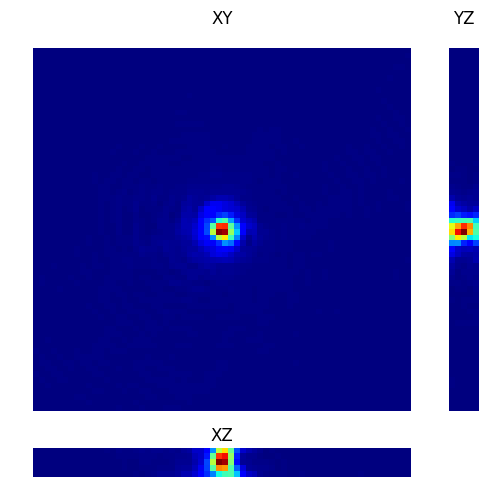

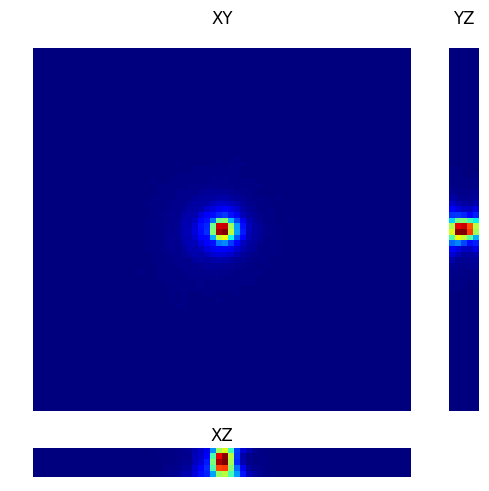

In [231]:
psf._gen_psf(pupil)
psf._PSFi=None
mip(psf.PSFi[[Ellipsis] + [slice(128-32, 128+32)]*2])
mip(test_data2[[Ellipsis] + [slice(128-32, 128+32)]*2])

In [233]:
from skimage.restoration import unwrap_phase

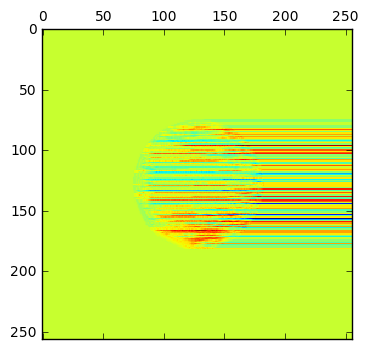

In [246]:
matshow(unwrap(ifftshift(angle(pupil) * psf._gen_pupil().real)))

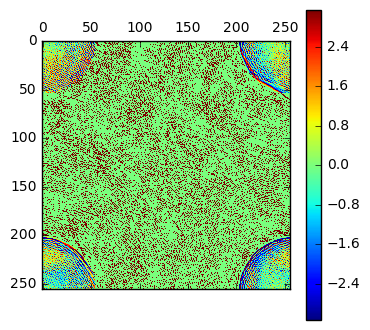

In [245]:
matshow(angle(pupil))
colorbar()